In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
rcParams=plt.rcParams

In [2]:
def unnormalize_sxr(normalized_values, sxr_norm):
    return 10 ** (normalized_values * float(sxr_norm[1].item()) + float(sxr_norm[0].item())) - 1e-8
def normalize_sxr(unnormalized_values, sxr_norm):
    """Convert from unnormalized to normalized space"""
    log_values = np.log10(unnormalized_values + 1e-8)
    normalized = (log_values - float(sxr_norm[0].item())) / float(sxr_norm[1].item())
    return normalized

In [3]:
def setup_barlow_font():
    """Setup Barlow font for matplotlib plots"""
    try:
        # Try to find Barlow font with more specific search
        barlow_fonts = []
        for font in fm.fontManager.ttflist:
            if 'barlow' in font.name.lower() or 'barlow' in font.fname.lower():
                barlow_fonts.append(font.name)

        if barlow_fonts:
            rcParams['font.family'] = 'Barlow'
            print(f"Using Barlow font: {barlow_fonts[0]}")
        else:
            # Try alternative approach - directly specify font file
            barlow_path = '/usr/share/fonts/truetype/barlow/Barlow-Regular.ttf'
            barlow_path2 = '/Users/griffingoodwin/Library/Fonts/Barlow-Regular.otf'
            if os.path.exists(barlow_path):
                # Add the font file directly to matplotlib
                fm.fontManager.addfont(barlow_path)
                rcParams['font.family'] = 'Barlow'
                print(f"Using Barlow font from: {barlow_path}")
            elif os.path.exists(barlow_path2):
                fm.fontManager.addfont(barlow_path2)
                rcParams['font.family'] = 'Barlow'
                print(f"Using Barlow font from: {barlow_path2}")
            else:
                # Fallback to sans-serif
                rcParams['font.family'] = 'sans-serif'
                print("Barlow font not found, using default sans-serif")
    except Exception as e:
        print(f"Font setup error: {e}, using default font")
setup_barlow_font()

Using Barlow font from: /Users/griffingoodwin/Library/Fonts/Barlow-Regular.otf


In [4]:
# train = pd.read_csv("/home/ggoodwin5/data/train_data_combined.csv")
# val = pd.read_csv("/home/ggoodwin5/data/val_data_combined.csv")
# test = pd.read_csv("/home/ggoodwin5/data/test_data_combined.csv")
# sxr_norms = np.load('/home/ggoodwin5/data/normalized_sxr.npy')
train = pd.read_csv("/Volumes/T9/data/train_data_combined.csv")
val = pd.read_csv("/Volumes/T9/data/val_data_combined.csv")
test = pd.read_csv("/Volumes/T9/data/test_data_combined.csv")
sxr_norms = np.load('/Volumes/T9/data/normalized_sxr.npy')

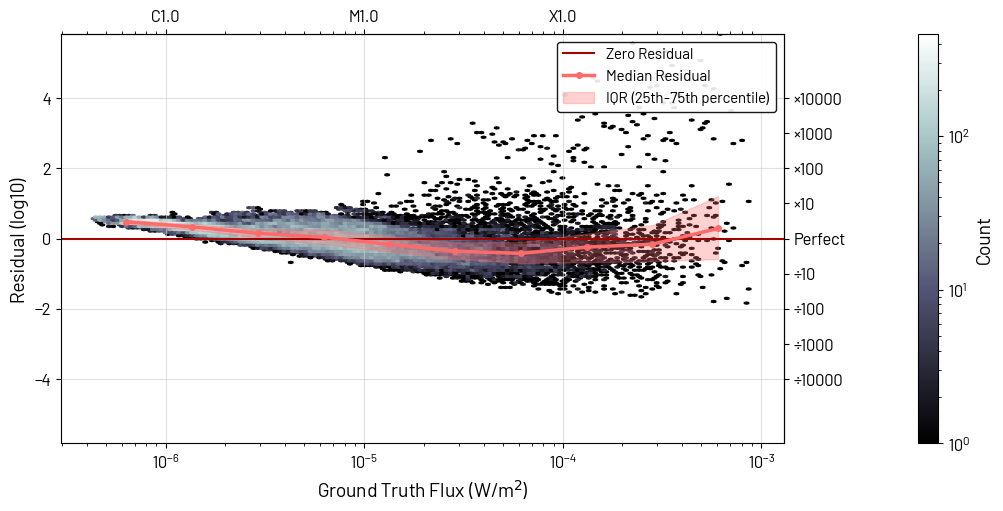

In [5]:
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.svm import SVR, LinearSVC
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, PredefinedSplit

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy.stats import pearsonr
import numpy as np

# Prepare features (X) and target (y)
feature_cols = [f'sum_flux_{w}' for w in ['94', '131', '171', '193', '211', '304', '335']]
X_train = train[feature_cols]
y_train = train['sxr_flux_normalized']

X_val = val[feature_cols]
y_val = val['sxr_flux_normalized']

# Define flare class boundaries (in unnormalized W/m^2)
def get_flare_class(sxr_flux):
    """
    Assign flare class based on SXR flux
    Returns: 'A', 'B', 'C', 'M', or 'X'
    """
    flux = np.abs(sxr_flux)
    if flux < 1e-6:
        return 'B'
    elif flux < 1e-5:
        return 'C'
    elif flux < 1e-4:
        return 'M'
    else:
        return 'X'

# Calculate sample weights for training based on flare class
def calculate_sample_weights(fluxes):
    weights = []
    for f in fluxes:
        if f < 1e-6:  # B
            weights.append(6.64)
        elif f < 1e-5:  # C
            weights.append(1.63)
        elif f < 1e-4:  # M
            weights.append(4.72)
        else:  # X
            weights.append(43.13)
    return np.array(weights)

# Resample training data based on weights (SVR doesn't support sample_weight directly)
# def weighted_resample(X, y, weights, random_state=42):
#     """
#     Resample data to approximate weighted training.
#     Samples with higher weights are more likely to be included multiple times.
#     """
#     np.random.seed(random_state)
#     # Normalize weights to probabilities
#     probs = weights / weights.sum()
#     # Resample with replacement based on weights
#     n_samples = len(X)
#     indices = np.random.choice(n_samples, size=n_samples, replace=True, p=probs)
#     return X.iloc[indices].reset_index(drop=True), y.iloc[indices].reset_index(drop=True)
#
# # Apply weighted resampling to training data
# train_weights = calculate_sample_weights(train['sxr_flux'])
# X_train_resampled, y_train_resampled = weighted_resample(X_train, y_train, train_weights)
#
# print(f"Original training size: {len(X_train)}")
# print(f"Resampled training size: {len(X_train_resampled)}")
#
# # Define hyperparameter grid for SVR with RBF kernel
# param_grid = {
#     'C': [100],
#     'gamma': ['scale'],
#     'epsilon': [0.1],
# }
#
# # Combine resampled train and val for GridSearchCV with PredefinedSplit
# X_combined = pd.concat([X_train_resampled, X_val])
# y_combined = pd.concat([y_train_resampled, y_val])
#
# # Create a list where train indices are -1 and val indices are 0
# split_index = [-1] * len(X_train_resampled) + [0] * len(X_val)
# pds = PredefinedSplit(test_fold=split_index)

# Perform Grid Search with PredefinedSplit
linear = LinearRegression()
# grid_search = GridSearchCV(estimator=svr, param_grid=param_grid,
#                            cv=pds, scoring="neg_mean_squared_error", n_jobs=-1, verbose=4)
linear.fit(X_train, y_train)

# Use the best model for subsequent evaluation
# svr_model = grid_search.best_estimator_
#
# print(f"Best parameters found: {grid_search.best_params_}")
# print(f"Best validation score (MSE): {-grid_search.best_score_}")

# Evaluation on Validation set with best model
y_pred_val = linear.predict(X_val)

# Un-normalize data for analysis
y_val_unnorm = np.maximum(val['sxr_flux'], 1e-8)
y_pred_val_unnorm = np.maximum(unnormalize_sxr(y_pred_val, sxr_norms), 1e-8)

# Calculate metrics in log scale
y_val_log = np.log10(y_val_unnorm)
y_pred_val_log = np.log10(y_pred_val_unnorm)

mse_log = mean_squared_error(y_val_log, y_pred_val_log)
r2_log = r2_score(y_val_log, y_pred_val_log)
pearson_log, _ = pearsonr(y_val_log, y_pred_val_log)

print(f"\n--- Validation Results ---")
print(f"Mean Squared Error (log scale) on Val: {mse_log}")
print(f"Pearson Correlation (log scale) on Val: {pearson_log}")


# Calculate per-class performance on validation set
print("\n--- Per-Class Performance (Validation) ---")
val_classes = np.array([get_flare_class(f) for f in val['sxr_flux']])
for cls in ['A', 'B', 'C', 'M', 'X']:
    mask = val_classes == cls
    if np.any(mask):
        cls_mse = mean_squared_error(y_val_log[mask], y_pred_val_log[mask])
        cls_rmse = np.sqrt(cls_mse)
        cls_mae = mean_absolute_error(y_val_log[mask], y_pred_val_log[mask])
        cls_r2 = r2_score(y_val_log[mask], y_pred_val_log[mask])
        if np.sum(mask) > 1:
            cls_pearson, _ = pearsonr(y_val_log[mask], y_pred_val_log[mask])
            pearson_str = f", Pearson={cls_pearson:.6f}"
        else:
            pearson_str = ", Pearson=N/A"
        print(f"  Class {cls}: MSE={cls_mse:.6f}, RMSE={cls_rmse:.6f}, MAE={cls_mae:.6f}, R²={cls_r2:.6f}{pearson_str}")

# ===== TEST SET EVALUATION =====
print("\n" + "="*60)
print("EVALUATING ON TEST SET")
print("="*60)

# Prepare test data
X_test = test[feature_cols]
y_test = test['sxr_flux_normalized']

# Make predictions on test set
y_pred_test = linear.predict(X_test)

# Un-normalize data for analysis
y_test_unnorm = np.maximum(test['sxr_flux'], 1e-8)
y_pred_test_unnorm = np.maximum(unnormalize_sxr(y_pred_test, sxr_norms), 1e-8)

# Calculate metrics in log scale
y_test_log = np.log10(y_test_unnorm)
y_pred_test_log = np.log10(y_pred_test_unnorm)

mse_test_log = mean_squared_error(y_test_log, y_pred_test_log)
rmse_test_log = np.sqrt(mse_test_log)
mae_test_log = mean_absolute_error(y_test_log, y_pred_test_log)
r2_test_log = r2_score(y_test_log, y_pred_test_log)
pearson_test_log, _ = pearsonr(y_test_log, y_pred_test_log)

print(f"\n--- Overall Test Results ---")
print(f"Mean Squared Error (log scale): {mse_test_log:.6f}")
print(f"Root Mean Squared Error (log scale): {rmse_test_log:.6f}")
print(f"Mean Absolute Error (log scale): {mae_test_log:.6f}")
print(f"Pearson Correlation (log scale): {pearson_test_log:.6f}")

# Calculate per-class performance on test set
print("\n--- Per-Class Performance (Test) ---")
test_classes = np.array([get_flare_class(f) for f in test['sxr_flux']])
for cls in ['A', 'B', 'C', 'M', 'X']:
    mask = test_classes == cls
    if np.any(mask):
        cls_mse = mean_squared_error(y_test_log[mask], y_pred_test_log[mask])
        cls_rmse = np.sqrt(cls_mse)
        cls_mae = mean_absolute_error(y_test_log[mask], y_pred_test_log[mask])
        cls_r2 = r2_score(y_test_log[mask], y_pred_test_log[mask])
        if np.sum(mask) > 1:
            cls_pearson, _ = pearsonr(y_test_log[mask], y_pred_test_log[mask])
            pearson_str = f", Pearson={cls_pearson:.4f}"
        else:
            pearson_str = ", Pearson=N/A"
        print(f"  Class {cls}: MSE={cls_mse:.6f}, RMSE={cls_rmse:.6f}, MAE={cls_mae:.6f}, {pearson_str}")

# Compare validation vs test performance
print("\n--- Validation vs Test Comparison ---")
print(f"{'Metric':<25} {'Validation':<15} {'Test':<15} {'Difference':<15}")
print("-" * 70)
print(f"{'MSE (log scale)':<25} {mse_log:<15.6f} {mse_test_log:<15.6f} {mse_test_log - mse_log:<15.6f}")
print(f"{'R² (log scale)':<25} {r2_log:<15.6f} {r2_test_log:<15.6f} {r2_test_log - r2_log:<15.6f}")
print(f"{'Pearson (log scale)':<25} {pearson_log:<15.6f} {pearson_test_log:<15.6f} {pearson_test_log - pearson_log:<15.6f}")

# ===== VISUALIZATION =====
print("\n" + "="*60)
print("GENERATING PLOTS")
print("="*60)

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.colors import LogNorm
import matplotlib.font_manager as fm
from matplotlib import rcParams, rc_params


def setup_barlow_font():
    """Setup Barlow font for matplotlib plots"""
    try:
        barlow_fonts = []
        for font in fm.fontManager.ttflist:
            if 'barlow' in font.name.lower() or 'barlow' in font.fname.lower():
                barlow_fonts.append(font.name)

        if barlow_fonts:
            rcParams['font.family'] = 'Barlow'
            print(f"Using Barlow font: {barlow_fonts[0]}")
        else:
            barlow_path = '/usr/share/fonts/truetype/barlow/Barlow-Regular.ttf'
            barlow_path2 = '/Users/griffingoodwin/Library/Fonts/Barlow-Regular.otf'
            if os.path.exists(barlow_path):
                fm.fontManager.addfont(barlow_path)
                rcParams['font.family'] = 'Barlow'
                print(f"Using Barlow font from: {barlow_path}")
            elif os.path.exists(barlow_path2):
                fm.fontManager.addfont(barlow_path2)
                rcParams['font.family'] = 'Barlow'
                print(f"Using Barlow font from: {barlow_path2}")
            else:
                rcParams['font.family'] = 'sans-serif'
                print("Barlow font not found, using default sans-serif")
    except Exception as e:
        print(f"Font setup error: {e}, using default font")

def plot_regression_with_residuals(y_true, y_pred, title=""):
    """
    Generate regression comparison plot with residuals subplot.
    """
    setup_barlow_font()

    flare_classes = {
        'A1.0': (1e-8, 1e-7),
        'B1.0': (1e-7, 1e-6),
        'C1.0': (1e-6, 1e-5),
        'M1.0': (1e-5, 1e-4),
        'X1.0': (1e-4, 1e-3),
        'X10.0': (1e-3, 1e-2),
        'X100.0': (1e-2, 1e-1),
        'X1000.0': (1e-1, 1)
    }

    theme = 'white'
    axis_facecolor = '#FFFFFF' if theme == 'white' else '#FFFFFF'
    text_color = 'black' if theme == 'white' else '#FFFFFF'
    legend_facecolor = '#FFFFFF' if theme == 'white' else '#1E1E2F'
    grid_color = '#CCCCCC' if theme == 'white' else '#3A3A5A'
    legend_edge_color = 'black' if theme == 'white' else '#3A3A5A'
    colorbar_facecolor = axis_facecolor
    figure_facecolor = '#FFFFFF' if theme == 'white' else '#000000'

    def add_flare_class_axes(ax, min_val, max_val, tick_color):
        def identity(x):
            return x
        ax_top = ax.secondary_xaxis('top', functions=(identity, identity))
        flare_positions = []
        flare_labels = []
        for class_name, (min_flux, max_flux) in flare_classes.items():
            if min_val <= min_flux <= max_val:
                flare_positions.append(min_flux)
                flare_labels.append(class_name)
        ax_top.set_xticks(flare_positions)
        ax_top.set_xticklabels(flare_labels, fontsize=12, color=tick_color, fontfamily='Barlow')
        ax_top.grid(False)

    def add_residual_class_axes(ax, tick_color):
        def identity(x):
            return x
        ax_right = ax.secondary_yaxis('right', functions=(identity, identity))
        residual_positions = [-4,-3,-2,-1,0,1,2,3,4]
        residual_labels = ["÷10000","÷1000","÷100","÷10","Perfect","×10","×100","×1000","×10000"]
        ax_right.set_yticks(residual_positions)
        ax_right.set_yticklabels(residual_labels, fontsize=12, color=tick_color, fontfamily='Barlow')

    fig, ax1 = plt.subplots(1, 1, figsize=(10, 5), layout='constrained')
    fig.patch.set_facecolor(figure_facecolor)
    fig.patch.set_alpha(1.0)

    residuals = np.log10(y_pred) - np.log10(y_true)
    h1 = ax1.hexbin(y_true, residuals, gridsize=150, cmap="bone", alpha=1, xscale="log", bins="log")
    ax1.axhline(y=0, color='#A00503', linestyle='-', linewidth=1.5, label='Zero Residual', zorder=10)

    min_val = min(y_true)
    max_val = max(y_true)
    n_bins = 10
    bin_edges = np.logspace(np.log10(min_val), np.log10(max_val), n_bins + 1)
    bin_centers = np.sqrt(bin_edges[:-1] * bin_edges[1:])
    median_residuals = []
    q25_residuals = []
    q75_residuals = []

    for i in range(n_bins):
        mask = (y_true >= bin_edges[i]) & (y_true < bin_edges[i+1])
        if np.sum(mask) > 5:
            median_residuals.append(np.median(residuals[mask]))
            q25_residuals.append(np.percentile(residuals[mask], 25))
            q75_residuals.append(np.percentile(residuals[mask], 75))
        else:
            median_residuals.append(np.nan)
            q25_residuals.append(np.nan)
            q75_residuals.append(np.nan)

    ax1.plot(bin_centers, median_residuals, color='#FF6B6B', linewidth=2.5,
             label='Median Residual', zorder=11, marker='o', markersize=4)
    ax1.fill_between(bin_centers, q25_residuals, q75_residuals,
                     color='#FF6B6B', alpha=0.3, label='IQR (25th-75th percentile)', zorder=9)

    ax1.set_facecolor(axis_facecolor)
    ax1.set_xlabel(r'Ground Truth Flux (W/m$^{2}$)', fontsize=14, color=text_color, fontfamily='Barlow')
    ax1.set_ylabel('Residual (log10)', fontsize=14, color=text_color, fontfamily='Barlow')
    ax1.tick_params(labelsize=12, colors=text_color)
    ax1.grid(True, alpha=0.6, color=grid_color)

    legend2 = ax1.legend(loc='upper right', prop={'family': 'Barlow', 'size': 11})
    legend2.get_frame().set_facecolor(legend_facecolor)
    legend2.get_frame().set_edgecolor(legend_edge_color)
    legend2.get_frame().set_alpha(0.9)
    for text in legend2.get_texts():
        text.set_color(text_color)
        text.set_fontfamily('Barlow')

    for label in ax1.get_xticklabels():
        label.set_fontfamily('Barlow')
        label.set_color(text_color)
    for label in ax1.get_yticklabels():
        label.set_fontfamily('Barlow')
        label.set_color(text_color)

    cbar = fig.colorbar(h1, ax=[ax1], orientation='vertical', pad=.1)
    cbar.ax.yaxis.set_tick_params(labelsize=12, colors=text_color)
    cbar.set_label("Count", fontsize=14, color=text_color, fontfamily='Barlow')
    cbar.ax.tick_params(colors=text_color)
    cbar.ax.yaxis.set_tick_params(colors=text_color)
    cbar.ax.yaxis.set_minor_locator(mticker.LogLocator(base=10, subs='auto', numticks=100))
    cbar.ax.tick_params(which='minor', colors=text_color)
    cbar.ax.set_facecolor(colorbar_facecolor)
    cbar.ax.patch.set_alpha(1.0)

    for label in cbar.ax.get_yticklabels():
        label.set_fontfamily('Barlow')
        label.set_color(text_color)

    for spine in ax1.spines.values():
        spine.set_color(text_color)
        spine.set_zorder(10)

    add_flare_class_axes(ax1, min_val, max_val, text_color)
    add_residual_class_axes(ax1, text_color)
    m = max(max(residuals), np.abs(min(residuals)))
    plt.ylim([-m, m])
    return fig, residuals

print("Generating test set plot...")
_, residuals = plot_regression_with_residuals(y_test_unnorm, y_pred_test_unnorm)

In [6]:
y_test_log = np.log10(y_test_unnorm)
y_pred_test_log = np.log10(y_pred_test_unnorm)

mse_test_log = mean_squared_error(y_test_log, y_pred_test_log)
rmse_test_log = np.sqrt(mse_test_log)
mae_test_log = mean_absolute_error(y_test_log, y_pred_test_log)
r2_test_log = r2_score(y_test_log, y_pred_test_log)
pearson_test_log, _ = pearsonr(y_test_log, y_pred_test_log)
mean_test_log = np.mean(y_pred_test_log-y_test_log)
print(f"\n--- Overall Test Results ---")
print(f"Mean Squared Error (log scale): {mse_test_log:.6f}")
print(f"Root Mean Squared Error (log scale): {rmse_test_log:.6f}")
print(f"Mean Absolute Error (log scale): {mae_test_log:.6f}")
print(f"Pearson Correlation (log scale): {pearson_test_log:.6f}")
print(f"Mean Bias Error (log scale): {mean_test_log:.6f}")

# Calculate per-class performance on test set
print("\n--- Per-Class Performance (Test) ---")
test_classes = np.array([get_flare_class(f) for f in test['sxr_flux']])
for cls in ['A', 'B', 'C', 'M', 'X']:
    mask = test_classes == cls
    if np.any(mask):
        cls_mse = mean_squared_error(y_test_log[mask], y_pred_test_log[mask])
        cls_rmse = np.sqrt(cls_mse)
        cls_mae = mean_absolute_error(y_test_log[mask], y_pred_test_log[mask])
        cls_r2 = r2_score(y_test_log[mask], y_pred_test_log[mask])
        cls_bias = np.mean(y_pred_test_log[mask]-y_test_log[mask])
        if np.sum(mask) > 1:
            cls_pearson, _ = pearsonr(y_test_log[mask], y_pred_test_log[mask])
            pearson_str = f", Pearson={cls_pearson:.4f}"
        else:
            pearson_str = ", Pearson=N/A"
        print(f"  Class {cls}: MSE={cls_mse:.6f}, RMSE={cls_rmse:.6f}, MAE={cls_mae:.6f}, {pearson_str}, Mean Bias={cls_bias:.6f}")


--- Overall Test Results ---
Mean Squared Error (log scale): 0.141106
Root Mean Squared Error (log scale): 0.375641
Mean Absolute Error (log scale): 0.306695
Pearson Correlation (log scale): 0.736917
Mean Bias Error (log scale): 0.116142

--- Per-Class Performance (Test) ---
  Class B: MSE=0.224782, RMSE=0.474112, MAE=0.468009, , Pearson=0.5710, Mean Bias=0.468009
  Class C: MSE=0.087566, RMSE=0.295915, MAE=0.249689, , Pearson=0.6360, Mean Bias=0.163493
  Class M: MSE=0.190324, RMSE=0.436261, MAE=0.349322, , Pearson=0.4189, Mean Bias=-0.225116
  Class X: MSE=1.187315, RMSE=1.089640, MAE=0.717550, , Pearson=0.4000, Mean Bias=-0.010033


In [7]:
res = pd.read_csv("/Volumes/T9/FOXES_Data/paper_res/vit/vit_predictions_removed_outliers.csv")
res_log_gt = np.log10(res['groundtruth'])
res_log_pred = np.log10(res['predictions'])


mse = mean_squared_error(res_log_gt, res_log_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(res_log_gt, res_log_pred)
pearson_vit, _ = pearsonr(res_log_gt, res_log_pred)
mean_bias_error = np.mean(res_log_pred - res_log_gt)
print(f"\n--- ViT Overall Performance ---")
print(mse)
print(rmse)
print(mae)
print(pearson_vit)
print(mean_bias_error)

# Calculate per-class performance for ViT
print("\n--- ViT Per-Class Performance ---")
vit_classes = np.array([get_flare_class(f) for f in res['groundtruth']])
for cls in ['A', 'B', 'C', 'M', 'X']:
    mask = vit_classes == cls
    if np.any(mask):
        cls_mse = mean_squared_error(res_log_gt[mask], res_log_pred[mask])
        cls_rmse = np.sqrt(cls_mse)
        cls_mae = mean_absolute_error(res_log_gt[mask], res_log_pred[mask])
        cls_r2 = r2_score(res_log_gt[mask], res_log_pred[mask])
        cls_bias = np.mean(res_log_pred[mask]-res_log_gt[mask])
        if np.sum(mask) > 1:
            cls_pearson, _ = pearsonr(res_log_gt[mask], res_log_pred[mask])
            pearson_str = f", Pearson={cls_pearson:.4f}"
        else:
            pearson_str = ", Pearson=N/A"
        print(f"  Class {cls}: MSE={cls_mse:.6f}, RMSE={cls_rmse:.6f}, MAE={cls_mae:.6f}, R²={cls_r2:.6f}{pearson_str}, n={np.sum(mask)}, Mean Bias={cls_bias:.6f}")


--- ViT Overall Performance ---
0.00622965204923954
0.07892814484858705
0.050938335018853816
0.9897400523126962
0.008326700533606415

--- ViT Per-Class Performance ---
  Class B: MSE=0.001148, RMSE=0.033882, MAE=0.026183, R²=0.804043, Pearson=0.9187, n=13600, Mean Bias=-0.004571
  Class C: MSE=0.003960, RMSE=0.062930, MAE=0.041601, R²=0.955488, Pearson=0.9803, n=63038, Mean Bias=0.002799
  Class M: MSE=0.014629, RMSE=0.120951, MAE=0.088443, R²=0.761006, Pearson=0.9007, n=22368, Mean Bias=0.034931
  Class X: MSE=0.028600, RMSE=0.169114, MAE=0.130467, R²=0.302692, Pearson=0.7102, n=1086, Mean Bias=-0.057240


In [8]:
res

,timestamp,predictions,groundtruth
0,2023-08-01T00:00:00,0.000003,0.000003
1,2023-08-01T00:01:00,0.000003,0.000003
2,2023-08-01T00:03:00,0.000003,0.000003
3,2023-08-01T00:04:00,0.000003,0.000003
4,2023-08-01T00:05:00,0.000003,0.000003
...,...,...,...
100087,2025-09-26T20:17:00,0.000004,0.000004
100088,2025-09-26T20:18:00,0.000004,0.000004
100089,2025-09-26T20:19:00,0.000003,0.000004
100090,2025-09-26T20:20:00,0.000003,0.000003


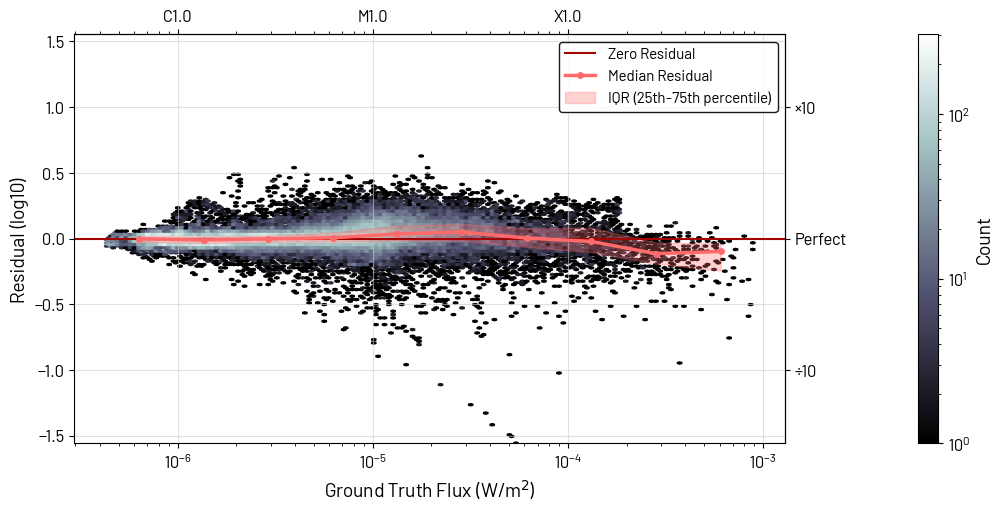

In [9]:
_, resid = plot_regression_with_residuals(res['groundtruth'],res['predictions'])

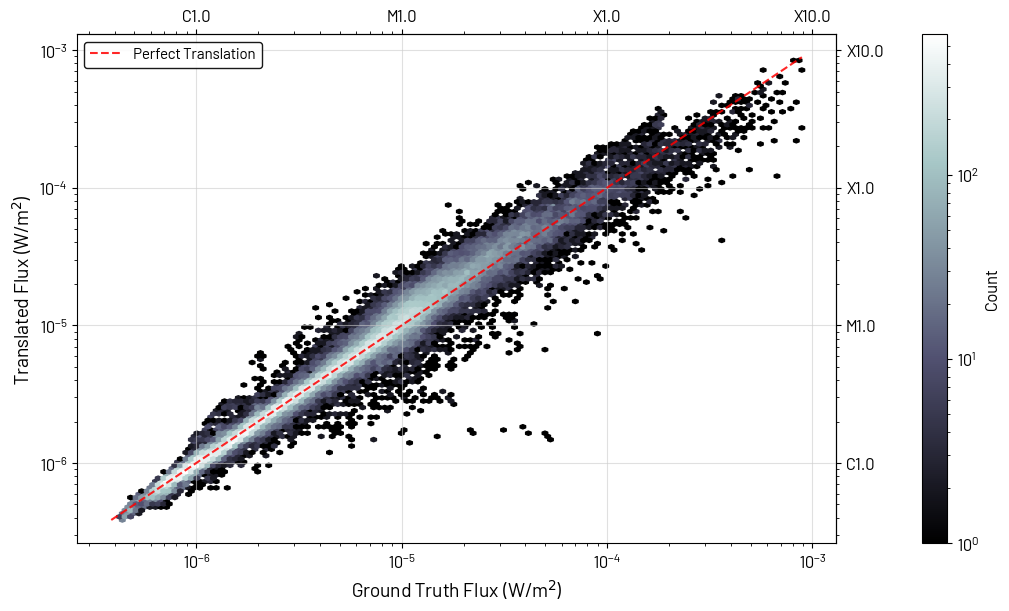

In [10]:
#import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import rcParams

theme = 'white'
axis_facecolor = '#FFFFFF' if theme == 'white' else '#FFFFFF'
text_color = 'black' if theme == 'white' else '#FFFFFF'
legend_facecolor = '#FFFFFF' if theme == 'white' else '#1E1E2F'
grid_color = '#CCCCCC' if theme == 'white' else '#3A3A5A'
minor_grid_color = '#E6E6E6' if theme == 'white' else '#1F1F35'
legend_edge_color = 'black' if theme == 'white' else '#3A3A5A'
colorbar_facecolor = axis_facecolor
figure_facecolor = '#FFFFFF' if theme == 'white' else '#000000'
def plot_solar_regression_hexbins(y_true, y_pred, cmap):
    # --- 1. Setup & Styling ---
    rcParams['font.family'] = 'sans-serif'
    rcParams['font.sans-serif'] = ['Barlow', 'Arial', 'DejaVu Sans']

    flare_classes = {
        'A1.0': (1e-8, 1e-7),
        'B1.0': (1e-7, 1e-6),
        'C1.0': (1e-6, 1e-5),
        'M1.0': (1e-5, 1e-4),
        'X1.0': (1e-4, 1e-3),
        'X10.0': (1e-3, 1e-2),
        'X100.0': (1e-2, 1e-1),
        'X1000.0': (1e-1, 1)
    }
    # Solar Flare Definitions
    def add_flare_class_axes(ax, min_val, max_val, tick_color):
            """
            Add flare class labels using true secondary axes that are
            mathematically tied to the parent axis.
            """

            # Identity transform (log space already handled by parent)
            def identity(x):
                return x

            # Create secondary axes
            ax_top = ax.secondary_xaxis('top', functions=(identity, identity))
            ax_right = ax.secondary_yaxis('right', functions=(identity, identity))
            # Collect tick positions + labels
            flare_positions = []
            flare_labels = []

            for class_name, (min_flux, max_flux) in flare_classes.items():
                if min_val <= min_flux <= 9999:
                    flare_positions.append(min_flux)
                    flare_labels.append(class_name)

            # Apply ticks
            ax_top.set_xticks(flare_positions)
            ax_top.set_xticklabels(
                flare_labels,
                fontsize=12,
                color=tick_color,
                fontfamily='Barlow'
            )

            # Remove grids + backgrounds (important)
            ax_top.grid(False)

            ax_right.set_yticks(flare_positions)
            ax_right.set_yticklabels(
                flare_labels,
                fontsize=12,
                color=tick_color,
                fontfamily='Barlow'
            )

            # Remove grids + backgrounds (important)
            ax_right.grid(False)

    # Data Prep
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    mask = (y_true > 0) & (y_pred > 0)
    y_true, y_pred = y_true[mask], y_pred[mask]


    # Limits
    vmin, vmax = 1e-9, 1e-2  # Fixed limits for standard solar range, or use min/max
    vmin = max(vmin, min(y_true.min(), y_pred.min()))
    vmax = min(vmax, max(y_true.max(), y_pred.max()))
    


    # --- 2. Figure Setup ---
    # Using constrained_layout to support secondary axes and colorbars
    fig = plt.figure(figsize=(10, 6), layout='constrained')
    gs = fig.add_gridspec(1, 1)

    ax_main = fig.add_subplot(gs[0])

    # --- 3. TOP PANEL: Prediction (Hexbin) ---
    # 'inferno' or 'magma' works well for "Heat/Solar" data
    hb1 = ax_main.hexbin(y_true, y_pred, gridsize=125, xscale='log', yscale='log',
                         cmap=cmap, mincnt=1, bins='log',
                         extent=(np.log10(vmin), np.log10(vmax), np.log10(vmin), np.log10(vmax)))
    
    # hb2 = ax_main.hexbin(new_y_true, new_y_pred, gridsize=100, xscale='log', yscale='log',
    #                      cmap='inferno', mincnt=1, bins='log',
    #                      extent=(np.log10(vmin), np.log10(vmax), np.log10(vmin), np.log10(vmax)))

    # 1:1 Line
    ax_main.plot([vmin, vmax], [vmin, vmax], ls='--', c='red', alpha=0.85, lw=1.5, label="Perfect Translation")

    # Decoration
    #ax_main.set_xlim(vmin, vmax)
    #ax_main.set_ylim(vmin, vmax)
    ax_main.set_xlabel(r'Ground Truth Flux (W/m$^{2}$)', fontsize=14)
    ax_main.set_ylabel(r'Translated Flux (W/m$^{2}$)', fontsize=14)
    ax_main.tick_params(labelsize=12, colors=text_color)
    ax_main.grid(True, alpha=0.6, color=grid_color)

    legend2 = ax_main.legend(loc='upper left', prop={'family': 'Barlow', 'size': 11})
    legend2.get_frame().set_facecolor(legend_facecolor)
    legend2.get_frame().set_edgecolor(legend_edge_color)
    legend2.get_frame().set_alpha(0.9)
    for text in legend2.get_texts():
        text.set_color(text_color)
        text.set_fontfamily('Barlow')

    # Set tick labels to Barlow font
    for label in ax_main.get_xticklabels():
        label.set_fontfamily('Barlow')
        label.set_color(text_color)
    for label in ax_main.get_yticklabels():
        label.set_fontfamily('Barlow')
        label.set_color(text_color)


    # --- 5. Colorbars ---
    cbar = fig.colorbar(hb1, ax=[ax_main], orientation='vertical')
    cbar.ax.yaxis.set_tick_params(labelsize=12, colors=text_color)
    cbar.set_label("Count", fontsize=12, color=text_color, fontfamily='Barlow')
    cbar.ax.tick_params(colors=text_color)
    cbar.ax.yaxis.set_tick_params(colors=text_color)
    cbar.ax.yaxis.set_minor_locator(mticker.LogLocator(base=10, subs='auto', numticks=100))
    cbar.ax.tick_params(which='minor', colors=text_color)
    cbar.ax.set_facecolor(colorbar_facecolor)
    cbar.ax.patch.set_alpha(1.0)
    vmin = max(vmin, min(y_true.min(), y_pred.min()))
    vmax = min(vmax, max(y_true.max(), y_pred.max()))
    add_flare_class_axes(ax_main, vmin, vmax, text_color)
    return fig


# Dummy data for testing

fig = plot_solar_regression_hexbins(y_test_unnorm, y_pred_test_unnorm, 'cividis')
#plt.savefig("RF_base.png",dpi=400)
#plt.show()

fig = plot_solar_regression_hexbins(res['groundtruth'],res['predictions'], 'bone')
#plt.savefig("vit_pred.png",dpi=400)
plt.show()



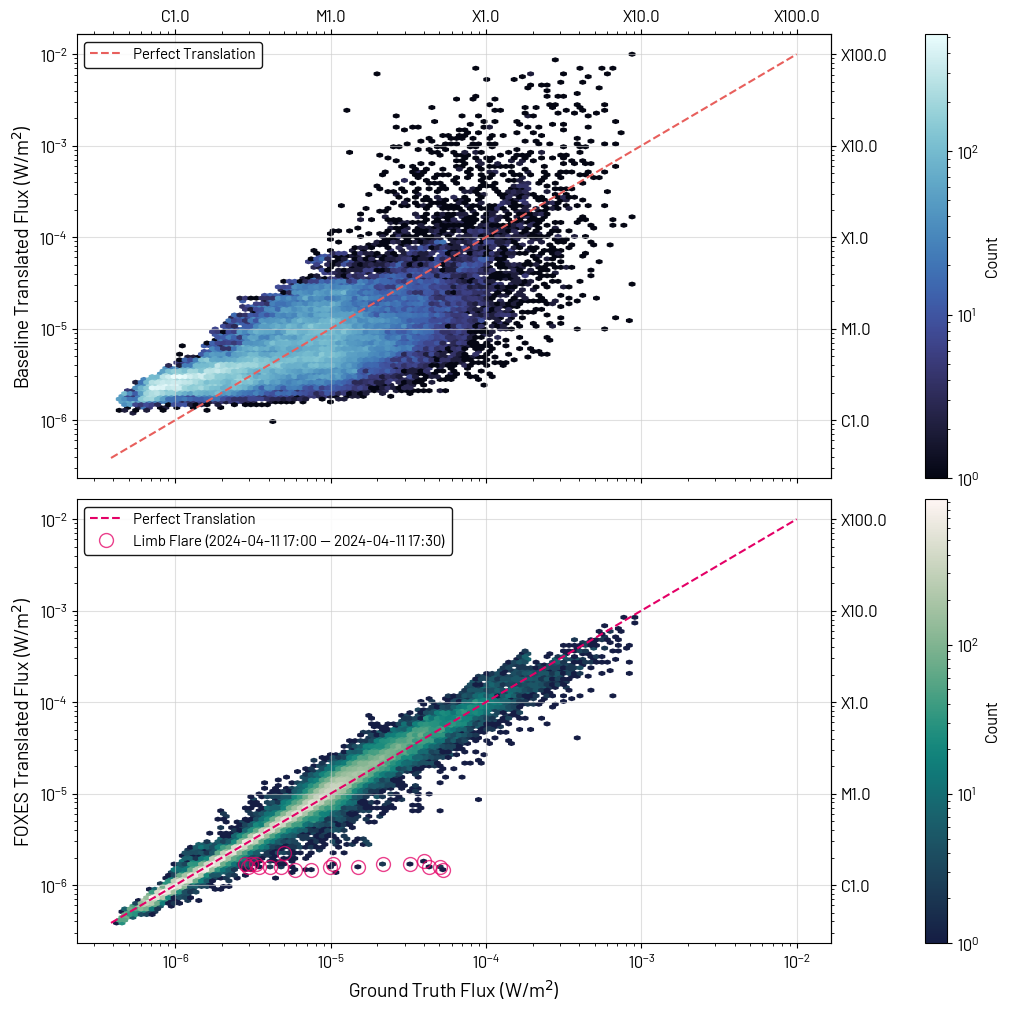

In [67]:
#import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import rcParams
from cmap import Colormap

theme = 'white'
axis_facecolor = '#FFFFFF' if theme == 'white' else '#FFFFFF'
text_color = 'black' if theme == 'white' else '#FFFFFF'
legend_facecolor = '#FFFFFF' if theme == 'white' else '#1E1E2F'
grid_color = '#CCCCCC' if theme == 'white' else '#3A3A5A'
minor_grid_color = '#E6E6E6' if theme == 'white' else '#1F1F35'
legend_edge_color = 'black' if theme == 'white' else '#3A3A5A'
colorbar_facecolor = axis_facecolor
figure_facecolor = '#FFFFFF' if theme == 'white' else '#000000'

def plot_solar_regression_hexbins_twopanel(y_true1, y_pred1, cmap1,
                                           y_true2, y_pred2, cmap2,
                                           timestamps2=None,
                                           highlight_start=None,
                                           highlight_end=None):
    rcParams['font.family'] = 'sans-serif'
    rcParams['font.sans-serif'] = ['Barlow', 'Arial', 'DejaVu Sans']

    flare_classes = {
        'A1.0': (1e-8, 1e-7),
        'B1.0': (1e-7, 1e-6),
        'C1.0': (1e-6, 1e-5),
        'M1.0': (1e-5, 1e-4),
        'X1.0': (1e-4, 1e-3),
        'X10.0': (1e-3, 1e-2),
        'X100.0': (1e-2, 1e-1),
        'X1000.0': (1e-1, 1)
    }

    def add_flare_class_axes(ax, min_val, max_val, tick_color,
                             add_top=True, add_right=True):
        def identity(x):
            return x

        flare_positions = []
        flare_labels = []
        for class_name, (min_flux, max_flux) in flare_classes.items():
            if min_val <= min_flux <= 9999:
                flare_positions.append(min_flux)
                flare_labels.append(class_name)

        if add_top:
            ax_top = ax.secondary_xaxis('top', functions=(identity, identity))
            ax_top.set_xticks(flare_positions)
            ax_top.set_xticklabels(flare_labels, fontsize=12,
                                   color=tick_color, fontfamily='Barlow')
            ax_top.grid(False)

        if add_right:
            ax_right = ax.secondary_yaxis('right', functions=(identity, identity))
            ax_right.set_yticks(flare_positions)
            ax_right.set_yticklabels(flare_labels, fontsize=12,
                                     color=tick_color, fontfamily='Barlow')
            ax_right.grid(False)

    # Data prep
    y_true1 = np.array(y_true1)
    y_pred1 = np.array(y_pred1)
    mask1 = (y_true1 > 0) & (y_pred1 > 0)
    y_true1, y_pred1 = y_true1[mask1], y_pred1[mask1]

    y_true2 = np.array(y_true2)
    y_pred2 = np.array(y_pred2)
    mask2 = (y_true2 > 0) & (y_pred2 > 0)
    # Also filter timestamps if provided
    if timestamps2 is not None:
        ts2 = pd.to_datetime(np.array(timestamps2))[mask2]
    y_true2, y_pred2 = y_true2[mask2], y_pred2[mask2]

    # Shared limits across both panels
    vmin = max(1e-9, min(y_true1.min(), y_pred1.min(),
                         y_true2.min(), y_pred2.min()))
    vmax = min(1e-2, max(y_true1.max(), y_pred1.max(),
                         y_true2.max(), y_pred2.max()))

    # Two-panel figure with shared x-axis
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10),
                                    layout='constrained', sharex=True)
    fig.patch.set_facecolor(figure_facecolor)

    extent = (np.log10(vmin), np.log10(vmax),
              np.log10(vmin), np.log10(vmax))

    # --- Top panel ---
    hb1 = ax1.hexbin(y_true1, y_pred1, gridsize=125, xscale='log',
                     yscale='log', cmap=cmap1, mincnt=1, bins='log',
                     extent=extent)
    ax1.plot([vmin, vmax], [vmin, vmax], ls='--', c='#e85f5c', alpha=1,
             lw=1.5, label="Perfect Translation")
    ax1.set_ylabel(r'Baseline Translated Flux (W/m$^{2}$)', fontsize=14)
    ax1.tick_params(labelsize=12, colors=text_color)
    ax1.grid(True, alpha=0.6, color=grid_color)
    ax1.set_facecolor(axis_facecolor)

    legend1 = ax1.legend(loc='upper left', prop={'family': 'Barlow', 'size': 11})
    legend1.get_frame().set_facecolor(legend_facecolor)
    legend1.get_frame().set_edgecolor(legend_edge_color)
    legend1.get_frame().set_alpha(0.9)
    for text in legend1.get_texts():
        text.set_color(text_color)
        text.set_fontfamily('Barlow')

    cbar1 = fig.colorbar(hb1, ax=ax1, orientation='vertical')
    cbar1.ax.yaxis.set_tick_params(labelsize=12, colors=text_color)
    cbar1.set_label("Count", fontsize=12, color=text_color, fontfamily='Barlow')
    cbar1.ax.tick_params(colors=text_color)
    cbar1.ax.yaxis.set_minor_locator(mticker.LogLocator(base=10, subs='auto', numticks=100))
    cbar1.ax.tick_params(which='minor', colors=text_color)
    cbar1.ax.set_facecolor(colorbar_facecolor)
    cbar1.ax.patch.set_alpha(1.0)

    # --- Bottom panel ---
    hb2 = ax2.hexbin(y_true2, y_pred2, gridsize=125, xscale='log',
                     yscale='log', cmap=cmap2, mincnt=1, bins='log',
                     extent=extent)
    ax2.plot([vmin, vmax], [vmin, vmax], ls='--', c="#E40066", alpha=1,
             lw=1.5, label="Perfect Translation")

    # Highlight hexbin cells that contain points within a time range
    if timestamps2 is not None and highlight_start is not None and highlight_end is not None:
        hl_start = pd.to_datetime(highlight_start)
        hl_end = pd.to_datetime(highlight_end)
        hl_mask = (ts2 >= hl_start) & (ts2 <= hl_end)
        if hl_mask.any():
            # Create a temporary invisible hexbin with only the highlighted
            # points, using the same grid, to get the bin centers
            hl_hb = ax2.hexbin(y_true2[hl_mask], y_pred2[hl_mask],
                               gridsize=125, xscale='log', yscale='log',
                               mincnt=1, bins='log', extent=extent, alpha=0)
            # get_offsets() returns centers in log10 space;
            # convert back to linear space for the log-scaled axes
            hl_centers = hl_hb.get_offsets()
            hl_hb.remove()

            ax2.plot(10**hl_centers[:, 0], 10**hl_centers[:, 1], 'o',
                     markerfacecolor='none', markeredgecolor='#E40066',
                     markeredgewidth=1, markersize=10, linestyle='none',
                     zorder=15,
                     label=f'Limb Flare ({highlight_start} \u2014 {highlight_end})',alpha=.75)

    ax2.set_xlabel(r'Ground Truth Flux (W/m$^{2}$)', fontsize=14)
    ax2.set_ylabel(r'FOXES Translated Flux (W/m$^{2}$)', fontsize=14)
    ax2.tick_params(labelsize=12, colors=text_color)
    ax2.grid(True, alpha=0.6, color=grid_color)
    ax2.set_facecolor(axis_facecolor)

    legend2 = ax2.legend(loc='upper left', prop={'family': 'Barlow', 'size': 11})
    legend2.get_frame().set_facecolor(legend_facecolor)
    legend2.get_frame().set_edgecolor(legend_edge_color)
    legend2.get_frame().set_alpha(0.9)
    for text in legend2.get_texts():
        text.set_color(text_color)
        text.set_fontfamily('Barlow')

    cbar2 = fig.colorbar(hb2, ax=ax2, orientation='vertical')
    cbar2.ax.yaxis.set_tick_params(labelsize=12, colors=text_color)
    cbar2.set_label("Count", fontsize=12, color=text_color, fontfamily='Barlow')
    cbar2.ax.tick_params(colors=text_color)
    cbar2.ax.yaxis.set_minor_locator(mticker.LogLocator(base=10, subs='auto', numticks=100))
    cbar2.ax.tick_params(which='minor', colors=text_color)
    cbar2.ax.set_facecolor(colorbar_facecolor)
    cbar2.ax.patch.set_alpha(1.0)

    # Barlow font for all tick labels and spines
    for ax in [ax1, ax2]:
        for label in ax.get_xticklabels() + ax.get_yticklabels():
            label.set_fontfamily('Barlow')
            label.set_color(text_color)
        for spine in ax.spines.values():
            spine.set_color(text_color)

    for cbar in [cbar1, cbar2]:
        for label in cbar.ax.get_yticklabels():
            label.set_fontfamily('Barlow')
            label.set_color(text_color)

    # Flare class secondary axes
    # Top panel: flare labels on top x-axis and right y-axis
    add_flare_class_axes(ax1, vmin, vmax, text_color,
                         add_top=True, add_right=True)
    # Bottom panel: right y-axis only (x-axis shared with top)
    add_flare_class_axes(ax2, vmin, vmax, text_color,
                         add_top=False, add_right=True)
    #plt.xlim([2e-7,2e-3])

    return fig


fig = plot_solar_regression_hexbins_twopanel(
    y_test_unnorm, y_pred_test_unnorm, Colormap('cmocean:ice').to_mpl(),
    res['groundtruth'], res['predictions'], Colormap('cmocean:tempo').to_mpl(),
    timestamps2=res['timestamp'],
    highlight_start='2024-04-11 17:00',
    highlight_end='2024-04-11 17:30'
)
plt.savefig("regression_2_panel.png", bbox_inches='tight',dpi=400)
plt.show()

In [14]:
print(Colormap('contrib:cerrado'))

Colormap(name='contrib:cerrado', <256 colors>)


In [ ]:
def residual_comparison(y_true, y_pred, new_y_true, new_y_pred):
    setup_barlow_font()

    flare_classes = {
        'A1.0': (1e-8, 1e-7),
        'B1.0': (1e-7, 1e-6),
        'C1.0': (1e-6, 1e-5),
        'M1.0': (1e-5, 1e-4),
        'X1.0': (1e-4, 1e-3),
        'X10.0': (1e-3, 1e-2),
        'X100.0': (1e-2, 1e-1),
        'X1000.0': (1e-1, 1)
    }

    theme = 'white'
    axis_facecolor = '#FFFFFF' if theme == 'white' else '#FFFFFF'
    text_color = 'black' if theme == 'white' else '#FFFFFF'
    legend_facecolor = '#FFFFFF' if theme == 'white' else '#1E1E2F'
    grid_color = '#CCCCCC' if theme == 'white' else '#3A3A5A'
    minor_grid_color = '#E6E6E6' if theme == 'white' else '#1F1F35'
    legend_edge_color = 'black' if theme == 'white' else '#3A3A5A'
    colorbar_facecolor = axis_facecolor
    figure_facecolor = '#FFFFFF' if theme == 'white' else '#000000'

    def add_flare_class_axes(ax, min_val, max_val, tick_color):
        """
        Add flare class labels using true secondary axes that are
        mathematically tied to the parent axis.
        """

        # Identity transform (log space already handled by parent)
        def identity(x):
            return x

        # Create secondary axes
        ax_top = ax.secondary_xaxis('top', functions=(identity, identity))

        # Collect tick positions + labels
        flare_positions = []
        flare_labels = []

        for class_name, (min_flux, max_flux) in flare_classes.items():
            if min_val <= min_flux <= max_val:
                flare_positions.append(min_flux)
                flare_labels.append(class_name)

        # Apply ticks
        ax_top.set_xticks(flare_positions)
        ax_top.set_xticklabels(
            flare_labels,
            fontsize=12,
            color=tick_color,
            fontfamily='Barlow'
        )

        # Styling
        # ax_top.tick_params(colors=tick_color, length=6, width=1)
        # ax_right.tick_params(colors=tick_color, length=6, width=1)

        # Remove grids + backgrounds (important)
        ax_top.grid(False)



    def add_residual_class_axes(ax, tick_color):
        """
        Add flare class labels using true secondary axes that are
        mathematically tied to the parent axis.
        """

        # Identity transform (log space already handled by parent)
        def identity(x):
            return x

        # Create secondary axes
        ax_right = ax.secondary_yaxis('right', functions=(identity, identity))

        # Collect tick positions + labels
        residual_positions = [-4,-3,-2,-1,0,1,2,3,4]
        residual_labels = ["÷10000","÷1000","÷100","÷10","Perfect","×10","×100","×1000","×10000"]


        # Apply ticks
        ax_right.set_yticks(residual_positions)
        ax_right.set_yticklabels(
            residual_labels,
            fontsize=12,
            color=tick_color,
            fontfamily='Barlow'
        )
        ax_right.grid(True)


    # Create figure with 2 subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), layout='constrained', sharex=True, sharey=True)

    # ===== TOP SUBPLOT: FIRST RESIDUALS =====
    # Calculate residuals in log space
    residuals = np.log10(y_pred) - np.log10(y_true)
    # Create 2D histogram for residuals
    h1 = ax1.hexbin(y_true, residuals, gridsize=150,
                    cmap="cividis", alpha=1, xscale="log", bins="log", extent=[min(np.log10(y_true)), max(np.log10(y_true)), -5, 5])

    # Add zero line (perfect prediction)
    ax1.axhline(y=0, color='#A00503', linestyle='-', linewidth=2, label='Zero Residual', zorder=10)
    
    # Styling ax1
    ax1.set_facecolor(axis_facecolor)
    ax1.set_ylabel('Residual (log10)', fontsize=14, color=text_color, fontfamily='Barlow')
    ax1.tick_params(labelsize=12, colors=text_color)
    ax1.grid(True, alpha=0.6, color=grid_color)

    # Legend for ax1
    legend1 = ax1.legend(loc='upper right', prop={'family': 'Barlow', 'size': 11})
    legend1.get_frame().set_facecolor(legend_facecolor)
    legend1.get_frame().set_edgecolor(legend_edge_color)
    legend1.get_frame().set_alpha(0.9)
    for text in legend1.get_texts():
        text.set_color(text_color)

    # Colorbar for ax1
    cbar1 = fig.colorbar(h1, ax=ax1, orientation='vertical', pad=.02)
    cbar1.ax.yaxis.set_tick_params(labelsize=12, colors=text_color)
    cbar1.set_label("Count", fontsize=14, color=text_color, fontfamily='Barlow')

    # ===== BOTTOM SUBPLOT: SECOND RESIDUALS =====
    residuals_new = np.log10(new_y_pred) - np.log10(new_y_true)
    h2 = ax2.hexbin(new_y_true, residuals_new, gridsize=150,
                    cmap="bone", alpha=1, xscale="log", bins="log", extent=[min(np.log10(y_true)), max(np.log10(y_true)), -5, 5])

    # Add zero line (perfect prediction)
    ax2.axhline(y=0, color='#A00503', linestyle='-', linewidth=2, label='Zero Residual', zorder=10)
    
    # Styling ax2
    ax2.set_facecolor(axis_facecolor)
    ax2.set_xlabel(r'Ground Truth Flux (W/m$^{2}$)', fontsize=14, color=text_color, fontfamily='Barlow')
    ax2.set_ylabel('Residual (log10)', fontsize=14, color=text_color, fontfamily='Barlow')
    ax2.tick_params(labelsize=12, colors=text_color)
    ax2.grid(True, alpha=0.6, color=grid_color)

    # Legend for ax2
    legend2 = ax2.legend(loc='upper right', prop={'family': 'Barlow', 'size': 11})
    legend2.get_frame().set_facecolor(legend_facecolor)
    legend2.get_frame().set_edgecolor(legend_edge_color)
    legend2.get_frame().set_alpha(0.9)
    for text in legend2.get_texts():
        text.set_color(text_color)

    # Colorbar for ax2
    cbar2 = fig.colorbar(h2, ax=ax2, orientation='vertical', pad=.02)
    cbar2.ax.yaxis.set_tick_params(labelsize=12, colors=text_color)
    cbar2.set_label("Count", fontsize=14, color=text_color, fontfamily='Barlow')

    # Apply Barlow font to all ticks
    for ax in [ax1, ax2]:
        for label in ax.get_xticklabels() + ax.get_yticklabels():
            label.set_fontfamily('Barlow')
            label.set_color(text_color)
        for spine in ax.spines.values():
            spine.set_color(text_color)
            spine.set_zorder(10)

    # Secondary axes for both
    vmin, vmax = 1e-9, 1e-2
    vmin = max(vmin, min(y_true.min(), y_pred.min()))
    vmax = min(vmax, max(y_true.max(), y_pred.max()))
    
    add_flare_class_axes(ax1, vmin, vmax, text_color)
    add_residual_class_axes(ax1, text_color)
    add_flare_class_axes(ax2, vmin, vmax, text_color)
    add_residual_class_axes(ax2, text_color)

    plt.ylim([-5, 5])
    return fig, residuals

residual_comparison(y_test_unnorm, y_pred_test_unnorm, res['groundtruth'],res['predictions'] )


In [ ]:
from scipy.stats import wilcoxon

# --- Wilcoxon Signed-Rank Test: Baseline vs FOXES ---
# Compares paired prediction errors (in log-space) between the two models

# Build aligned DataFrames using timestamps
baseline_results = pd.DataFrame({
    'timestamp': pd.to_datetime(test['timestamp']),
    'gt': y_test_unnorm,
    'pred_baseline': y_pred_test_unnorm
})

foxes_results = pd.DataFrame({
    'timestamp': pd.to_datetime(res['timestamp']),
    'gt_foxes': res['groundtruth'].values,
    'pred_foxes': res['predictions'].values
})

# Merge on timestamp to get paired samples
merged = baseline_results.merge(foxes_results, on='timestamp', how='inner')
print(f"Paired samples: {len(merged)} (from {len(baseline_results)} baseline, {len(foxes_results)} FOXES)")

# Compute errors in log-space
merged['abs_err_baseline'] = np.abs(np.log10(merged['pred_baseline']) - np.log10(merged['gt']))
merged['abs_err_foxes'] = np.abs(np.log10(merged['pred_foxes']) - np.log10(merged['gt']))
merged['sq_err_baseline'] = (np.log10(merged['pred_baseline']) - np.log10(merged['gt'])) ** 2
merged['sq_err_foxes'] = (np.log10(merged['pred_foxes']) - np.log10(merged['gt'])) ** 2

# Assign flare classes based on ground truth
merged['flare_class'] = merged['gt'].apply(get_flare_class)

results = []

for metric_name, err_col_bl, err_col_fx, agg_label in [
    ('MAE', 'abs_err_baseline', 'abs_err_foxes', 'MAE'),
    ('RMSE', 'sq_err_baseline', 'sq_err_foxes', 'RMSE'),
]:
    print(f"\n{'='*90}")
    print(f"WILCOXON SIGNED-RANK TEST: Baseline vs FOXES — {metric_name} (log-space)")
    print(f"{'='*90}")
    print(f"H0: No difference in per-sample {'absolute' if metric_name == 'MAE' else 'squared'} errors between models")
    print(f"H1: Per-sample {'absolute' if metric_name == 'MAE' else 'squared'} errors differ between models\n")
    print(f"{'Class':<10} {'N':>8} {'Baseline '+agg_label:>16} {'FOXES '+agg_label:>14} {'Statistic':>14} {'p-value':>14} {'Sig (p<.05)':>12}")
    print("-" * 88)

    for cls in ['B', 'C', 'M', 'X', 'Overall']:
        if cls == 'Overall':
            mask = np.ones(len(merged), dtype=bool)
        else:
            mask = merged['flare_class'] == cls

        n = mask.sum()
        if n < 10:
            print(f"  {cls:<10} {n:>8}  (insufficient samples)")
            continue

        bl_err = merged.loc[mask, err_col_bl].values
        fx_err = merged.loc[mask, err_col_fx].values

        if metric_name == 'RMSE':
            bl_agg = np.sqrt(np.mean(bl_err))
            fx_agg = np.sqrt(np.mean(fx_err))
        else:
            bl_agg = np.mean(bl_err)
            fx_agg = np.mean(fx_err)

        # Wilcoxon signed-rank test on paired differences
        diff = bl_err - fx_err
        nonzero = diff != 0
        if nonzero.sum() < 10:
            print(f"  {cls:<10} {n:>8}  (insufficient non-zero differences)")
            continue

        stat, p_value = wilcoxon(diff[nonzero], alternative='two-sided')
        sig = "Yes" if p_value < 0.05 else "No"

        print(f"  {cls:<10} {n:>8} {bl_agg:>16.6f} {fx_agg:>14.6f} {stat:>14.1f} {p_value:>14.2e} {sig:>12}")

        results.append({
            'Metric': metric_name,
            'Flare Class': cls,
            'N': n,
            f'Baseline {agg_label} (log)': round(bl_agg, 6),
            f'FOXES {agg_label} (log)': round(fx_agg, 6),
            'Wilcoxon Statistic': stat,
            'p-value': p_value,
            'Significant (p<0.05)': sig
        })

wilcoxon_df = pd.DataFrame(results)
print(f"\nPositive difference (Baseline - FOXES) means FOXES performs better.")
wilcoxon_df

In [ ]:
import matplotlib.dates as mdates

setup_barlow_font()

# Load FOXES predictions with timestamps
res_ts = res.copy()
res_ts['timestamp'] = pd.to_datetime(res_ts['timestamp'])
res_ts = res_ts.sort_values('timestamp')

# All windows are 24 hours so panels share the same x-axis
panels = [
    ('2023-08-05 16:00', '2023-08-06 06:00', 'X-Class Activity — Aug 5–6'),
    ('2023-08-07 14:00', '2023-08-08 04:00', 'X-Class Activity — Aug 7–8'),
    ('2023-08-01 13:00', '2023-08-02 03:00', 'M-class Activity — Aug 1-2'),
    ('2023-08-14 05:00', '2023-08-14 19:00', 'Quiet Period — Aug 14'),
]

# Flare class thresholds for horizontal reference lines
flare_thresholds = {
    'C1.0': 1e-6,
    'M1.0': 1e-5,
    'X1.0': 1e-4,
}

# Theme
text_color = 'black'
grid_color = '#CCCCCC'

fig, axes = plt.subplots(len(panels), 1, figsize=(8.5, 10),
                         layout='constrained', sharex=True, sharey=True)

for i, (ax, (t_start, t_end, title)) in enumerate(zip(axes, panels)):
    t_start_dt = pd.to_datetime(t_start)
    t_end_dt = pd.to_datetime(t_end)

    mask = (res_ts['timestamp'] >= t_start_dt) & (res_ts['timestamp'] <= t_end_dt)
    window = res_ts[mask].copy()

    # Compute hours elapsed from the start of each window
    window['hours_elapsed'] = (window['timestamp'] - t_start_dt).dt.total_seconds() / 3600.0

    # Plot ground truth (GOES) and FOXES predictions vs relative time
    ax.plot(window['hours_elapsed'], window['groundtruth'],
            color='#F78E69', linewidth=1.8, label='GOES (Ground Truth)')
    ax.plot(window['hours_elapsed'], window['predictions'],
            color='#7B68AE', linewidth=1.8, label='FOXES', alpha=0.9)

    # Flare class threshold lines
    for cls_name, threshold in flare_thresholds.items():
        ax.axhline(y=threshold, color=grid_color, linestyle='--', linewidth=0.8, alpha=0.7)
        ax.text(0.15, threshold * 1.1, cls_name,
                fontsize=9, color='gray', fontfamily='Barlow', va='bottom')

    ax.set_yscale('log')
    ax.set_ylabel(r'SXR Flux (W/m$^{2}$)', fontsize=12, color=text_color, fontfamily='Barlow')
    ax.set_title(title, fontsize=13, color=text_color, fontfamily='Barlow', loc='left')
    ax.grid(True, alpha=0.4, color=grid_color, which='major')
    ax.grid(True, alpha=0.15, color=grid_color, which='minor', linestyle='--')
    ax.tick_params(labelsize=11, colors=text_color)

    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontfamily('Barlow')

    for spine in ax.spines.values():
        spine.set_color(text_color)

# Shared x-axis label only on the bottom panel
axes[-1].set_xlabel('Time From Observation Start (Hours)', fontsize=12, color=text_color, fontfamily='Barlow')
axes[-1].set_xlim(0, 14)

# Single legend at the top
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=2,
           fontsize=12, frameon=True,
           prop={'family': 'Barlow', 'size': 12},
           bbox_to_anchor=(0.8, 1.02))

plt.savefig('foxes_temporal_coherence.png', dpi=400, bbox_inches='tight')
plt.show()

In [ ]:
import sunpy.visualization.colormaps as cm

setup_barlow_font()

# --- Limb flare case study: April 11, 2024 ---
# FOXES cannot detect the flare because it's on the solar limb,
# while GOES measures full-disk SXR flux and sees the event.

aia_dir = '/Volumes/T9/FOXES_Data/AIA/test'
wavs = ['94', '131', '171', '193', '211', '304', '335']
aia_cmaps = [cm.cmlist[f'sdoaia{w}'] for w in wavs]

# Full 1-minute cadence burst across the flare: 16:55 – 17:12 (18 frames)
burst_times = [f'2024-04-11T{17 if m >= 60 else 16}:{(m % 60):02d}:00'
               for m in range(55, 73)]  # 16:55 to 17:12
ncols = 6
nrows_aia = len(burst_times) // ncols  # 3 rows

# Show 131 Å (channel 1) — best for flare emission
wav_idx = 1
wav_name = wavs[wav_idx]

# Load prediction data for the time series
res_ts = res.copy()
res_ts['timestamp'] = pd.to_datetime(res_ts['timestamp'])
limb_window = res_ts[(res_ts['timestamp'] >= '2024-04-11 16:40') &
                     (res_ts['timestamp'] <= '2024-04-11 17:20')]

# Layout: 3 rows of AIA burst + 1 time series row
fig = plt.figure(figsize=(16, 12), layout='constrained')
gs = fig.add_gridspec(nrows_aia + 1, ncols,
                      height_ratios=[1] * nrows_aia + [1.4], hspace=0.2)

text_color = 'black'
grid_color = '#CCCCCC'
t0 = limb_window['timestamp'].iloc[0]

# --- Top rows: AIA 131 Å burst at 1-min cadence ---
for i, ts in enumerate(burst_times):
    row = i // ncols
    col = i % ncols
    ax = fig.add_subplot(gs[row, col])
    aia = np.load(f'{aia_dir}/{ts}.npy')
    ax.imshow(aia[wav_idx], cmap=aia_cmaps[wav_idx], origin='lower',
              vmin=-1, vmax=1)
    t_label = ts[11:16]  # "HH:MM"
    ax.set_title(t_label, fontsize=10, fontfamily='Barlow', color=text_color)
    ax.axis('off')

fig.text(0.005, 0.82, f'AIA {wav_name} Å', fontsize=13, fontfamily='Barlow',
         color=text_color, va='center', rotation=90)

# --- Bottom: time series ---
ax_ts = fig.add_subplot(gs[nrows_aia, :])

minutes = (limb_window['timestamp'] - t0).dt.total_seconds() / 60.0

ax_ts.plot(minutes, limb_window['groundtruth'],
           color='#F78E69', linewidth=2, label='GOES (Ground Truth)')
ax_ts.plot(minutes, limb_window['predictions'],
           color='#7B68AE', linewidth=2, label='FOXES', alpha=0.9)

# Shade the burst window on the time series
burst_start = (pd.to_datetime(burst_times[0]) - t0).total_seconds() / 60.0
burst_end = (pd.to_datetime(burst_times[-1]) - t0).total_seconds() / 60.0
ax_ts.axvspan(burst_start, burst_end, alpha=0.08, color='gray')

# Flare class thresholds
for cls, thr in [('C1.0', 1e-6), ('M1.0', 1e-5), ('X1.0', 1e-4)]:
    ax_ts.axhline(thr, color=grid_color, linestyle='--', linewidth=0.8, alpha=0.7)
    ax_ts.text(minutes.iloc[0] + 0.3, thr * 1.15, cls,
               fontsize=9, color='gray', fontfamily='Barlow', va='bottom')

ax_ts.set_yscale('log')
ax_ts.set_xlabel('Time from start (minutes)', fontsize=12, fontfamily='Barlow', color=text_color)
ax_ts.set_ylabel(r'SXR Flux (W/m$^{2}$)', fontsize=12, fontfamily='Barlow', color=text_color)
ax_ts.set_title('Limb Flare — April 11, 2024', fontsize=13, fontfamily='Barlow',
                color=text_color, loc='left')
ax_ts.grid(True, alpha=0.4, color=grid_color, which='major')
ax_ts.grid(True, alpha=0.15, color=grid_color, which='minor', linestyle='--')
ax_ts.tick_params(labelsize=11, colors=text_color)

legend = ax_ts.legend(fontsize=11, loc='upper right', prop={'family': 'Barlow', 'size': 11})
legend.get_frame().set_facecolor('white')
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_alpha(0.9)

for label in ax_ts.get_xticklabels() + ax_ts.get_yticklabels():
    label.set_fontfamily('Barlow')
for spine in ax_ts.spines.values():
    spine.set_color(text_color)

plt.savefig('limb_flare_april11.png', dpi=400, bbox_inches='tight')
plt.show()